**<font color="#D81E5B ">Name</font>:** Ayomide Omolewa <br>
**<font color="#D81E5B ">Assignment Description</font>:** Random Forest Classification on Titanic Dataset <br>
**<font color="#D81E5B ">Completion Date</font>:** 12/01/2021 <br>

Remove warnings

In [1]:
import warnings; warnings.simplefilter('ignore')

### <font color="#F0544F">Intro</font>
    
For my final project, I will be using the titanic dataset found on <a href="https://www.kaggle.com/c/titanic/data?select=train.csv">kaggle</a>
    
My goal is to predict the **Survived** class based on the other features. This data is already split into train/test so we can just read these two values seperately

Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read train and test data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Analyze raw data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From here, we can already see some variables that can be removed. I've decided to remove PassengerID as it is a repeat of the index but it starts at 1, and Name as someones name wouldn't determine whether they survived or not.

**<font color="#D81E5B ">Variables to Remove so far</font>**:
* PassengerId
* Name

### <font color="#F0544F"> Visualization

Looking at the dataset, I can make the assumption that Age, Pclass (1st, 2nd, and 3rd class) and sex (male, female) also played a huge role. This is because, the wealthiest are always the first to survive and women and children left the boat before women. Lets visualize this to make sure.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

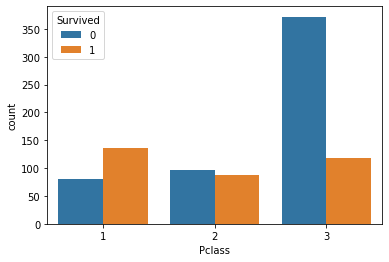

In [6]:
sns.countplot(x=train['Pclass'], hue=train['Survived'])

<AxesSubplot:xlabel='Sex', ylabel='count'>

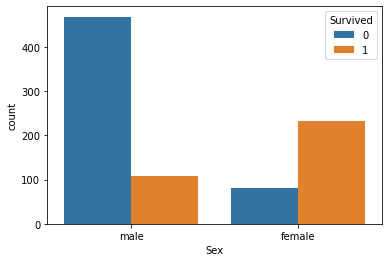

In [7]:
sns.countplot(x=train['Sex'], hue=train['Survived'])

<AxesSubplot:xlabel='Survived', ylabel='Age'>

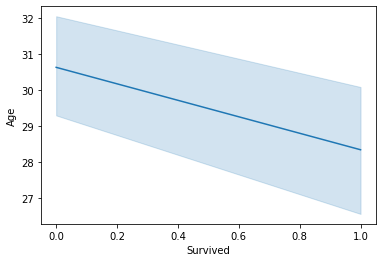

In [8]:
sns.lineplot(x=train['Survived'], y=train['Age'])

These 3 are obvious cases to be in the random forest classification, but what about the rest?

**<font color="#D81E5B ">Cabin</font>**: This variable has nearly 700 nulls, for this reason I believe it'd be better to remove this variable.<br>
**<font color="#D81E5B ">SibSp</font>**: Number of siblings/spouses, I don't believe this will yield any meaningful results, but I'll visualize it anyway.<br>
**<font color="#D81E5B ">parch</font>**: Similar to the previous variable, it represent # of parents/children on board. <br>
**<font color="#D81E5B ">ticket number</font>**: I've decided to remove this variable as it shouldn't be any more informative than the **Pclass** variable.<br>
**<font color="#D81E5B ">fare</font>**: A higher class results in a higher fare, so I believe this correlates with **Pclass** and can be removed.<br>
**<font color="#D81E5B ">embarked</font>**: This variable can also be removed as the destination from where the passenger left wouldn't affect whether they survived or not.<br>

<AxesSubplot:xlabel='SibSp', ylabel='count'>

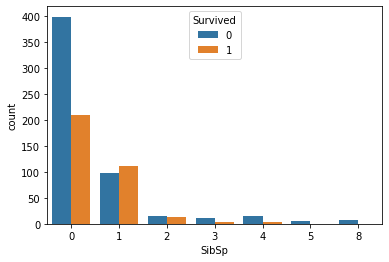

In [9]:
sns.countplot(x=train['SibSp'], hue=train['Survived'])

<AxesSubplot:xlabel='Parch', ylabel='count'>

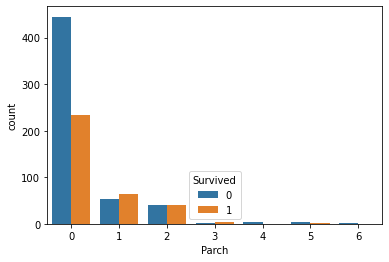

In [10]:
sns.countplot(x=train['Parch'], hue=train['Survived'])

As I suspected, it doesn't seem that the amount of relatives on board had any significant affect on whether a passenger survived or not

**<font color="#D81E5B ">Variables to Remove so far</font>**:
* PassengerId
* Name
* Parch
* SibSp
* Cabin
* Ticket
* Fare
* Embarked

### <font color="#F0544F">Data Wrangling</font>

After removing so many variables, we are left with **<font color="#D81E5B ">Age</font>**, **<font color="#D81E5B ">Sex</font>**, and **<font color="#D81E5B ">Pclass</font>**. Lets subset the train and test values to only include these 3 columns, as well as create a seperate column for the survived column.

In [11]:
new_train_x = train[['Age', 'Sex', 'Pclass']]
new_train_y = train['Survived']

new_test_x = test[['Age', 'Sex', 'Pclass']]

In [12]:
new_train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     714 non-null    float64
 1   Sex     891 non-null    object 
 2   Pclass  891 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 21.0+ KB


We can see that Age has about 150 Null values, and that Sex is an object instead of a classification. First, lets fill in all the null values for Age using the mean age of each class from the entire dataset.

In [13]:
age_group = new_train_x.groupby(['Pclass'])['Age']
new_train_x['Age'] = age_group.transform(lambda x: x.fillna(x.mean()))

age_group = new_test_x.groupby(['Pclass'])['Age']
new_test_x['Age'] = age_group.transform(lambda x: x.fillna(x.mean()))

In [14]:
new_train_x.isnull().sum()

Age       0
Sex       0
Pclass    0
dtype: int64

Now, we want to make Sex a categorical variable, to do so we can use sklearns LabelEncoder

In [15]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
new_train_x['Pclass'] = le.fit_transform(new_train_x['Pclass'])
new_train_x['Sex'] = le.fit_transform(new_train_x['Sex'])

new_test_x['Pclass'] = le.fit_transform(new_test_x['Pclass'])
new_test_x['Sex'] = le.fit_transform(new_test_x['Sex'])

### <font color="#F0544F">Final Variable Values</font>

**<font color="#D81E5B ">Age</font>**:
* Any integer

**<font color="#D81E5B ">Sex</font>**:
* 0 = Male
* 1 = Female

**<font color="#D81E5B ">Pclass</font>**:
* 1 = 1st Class (best)
* 2 = 2nd Class
* 3 = 3rd Class (worst)

### <font color="#F0544F">Random Forest Classification

Import random forest libraries

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Create random forest
* set random_state to 0 for reproducable results
* n_estimators to 5 because this seemed to produce maximum results for the data.

In [17]:
randomforest = RandomForestClassifier(random_state=0, n_estimators = 5)

Use the X and y values to create the randomforest

In [18]:
model = randomforest.fit(new_train_x, new_train_y)

Now we have a model made from randomforest that we can use to predict future values.

First Observation: 45 Year Old Woman, 1st Class<br>
Second Observation: 45 Year Old Man, 1st Class<br>
<br>
First Prediction: Surived<br>
Second PRediction: Did not survive<br>

In [19]:
test_prediction = [[45, 0, 1], [45, 1, 1]]
model.predict(test_prediction)

array([1, 0], dtype=int64)

### <font color="#F0544F">Feature Importance

In [20]:
importances = model.feature_importances_

In [21]:
indices = np.argsort(importances)[::-1]

In [22]:
names = [new_train_x.columns[i] for i in indices] #rearrance feature names

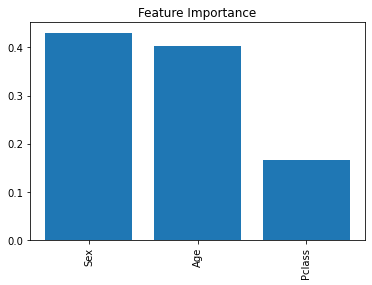

In [23]:
plt.figure()
plt.title("Feature Importance")
plt.bar(range(new_train_x.shape[1]), importances[indices])
plt.xticks(range(new_train_x.shape[1]), names, rotation=90)
plt.show()

From this plot, we can see that Sex and Age were the most important variables in determining whether a user survived or not, while PClass was only half as important as those two. However, Pclass is still an important variable as it accounts for nearly 20% of the feature importance. Because of this, I decided not to redo my random forest with a threshold, as all 3 variables already beat the threshold of 10%

### <font color="#F0544F">Final Prediction and Analysis

Create predictions from test

In [24]:
predictions = model.predict(new_test_x)

Merge passenger ID with predictions, and save predictions as a new CSV

In [25]:
predictions = pd.DataFrame(predictions, columns=['Survived'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv('test_predictions.csv', sep=",", index = False)

Unfortunately, the test survival csv isn't available as this is a competition for kaggle. However, upon submitting this I found out that my prediction had a **<font color="#D81E5B ">0.72488</font>** accuracy. All in all, I think this is pretty good for a simple guess of whether a passenger survived or not. My reasoning is, in a practical example where someone would want to predict if they would survive or not. They would really only be able to provide their sex and age and class. I purposefully didn't add Fare because the cost of a 1st class ticket in 1912 compared to 2021 is beyond the scope of this project. However, everyone knows how much they would spend on a ticket in this day and age. Having the prices for the 1st, 2nd, and 3rd class tickets available as options with their estimated price would be a more efficient way to categorize people in 2021. This means, if someone wanted to see if they could survive on the titanic, all they would need to know is their budget and which category their budget falls into. Average prediction accuracy was about 75-80%